# PIV Masks

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
%matplotlib inline
import pandas as pd
import xarray as xr
import matplotlib.image as mpimg
import IPython ## 
from IPython import display
display.set_matplotlib_formats('retina')

### Daytime

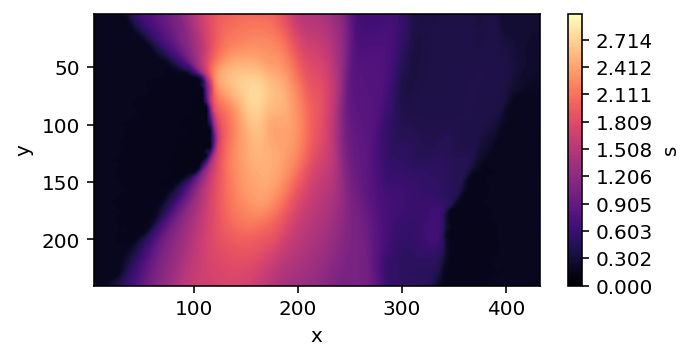

In [556]:
PIVpath = '/Volumes/LaCie/Velocimetry/Site5/0802/DJI_0002_20180802_VelPt5_1350_304.9mAGL.nc'
PIV_0802_1350 = xr.open_dataset(PIVpath)
PIV_0802_1350.s.mean(dim='time').transpose().plot.contourf(
    levels=200,yincrease=False, vmin=0, vmax=3,cmap=cm.magma, figsize=(5,2.5 ))

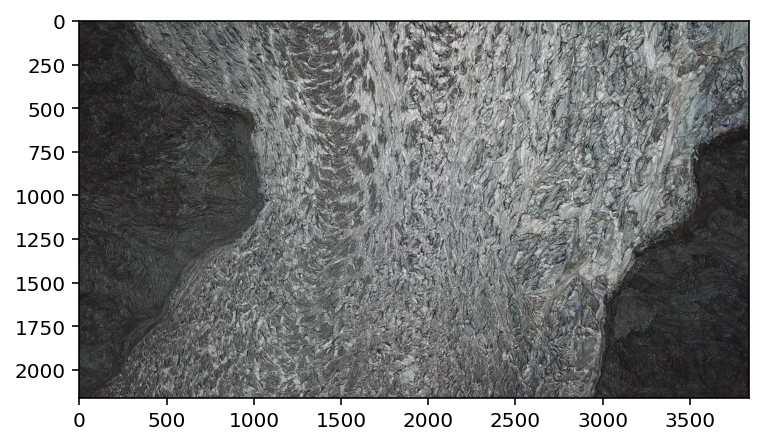

In [574]:
pathIn = '/Volumes/LaCie/Velocimetry/Site5/0802/DJI_0002_20180802_VelPt5_1350_304.9mAGL.MOV'
vidcap = cv2.VideoCapture(pathIn)
success, img = vidcap.read()
img.shape
imgplot = plt.imshow(img)
plt.show()

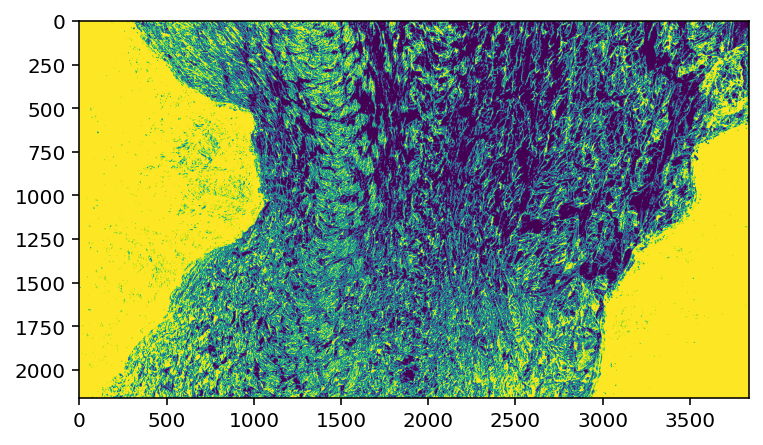

In [588]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
threshplot = plt.imshow(thresh)
#plt.show()

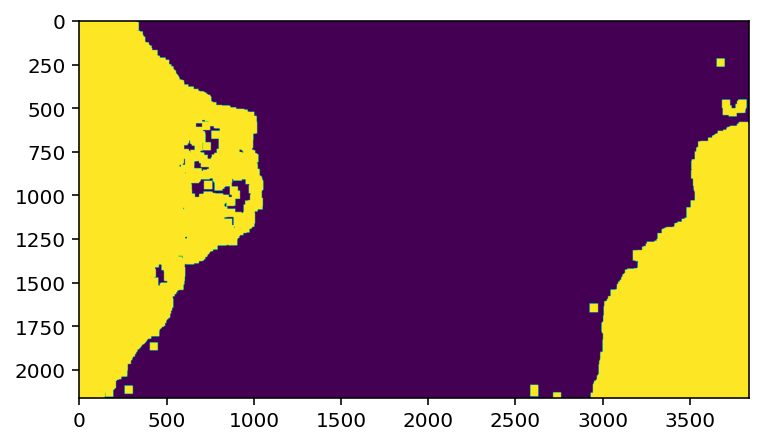

In [576]:
# noise removal
kernel = np.ones((10,10),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
#sure_bg = 1 - sure_bg
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(sure_bg)

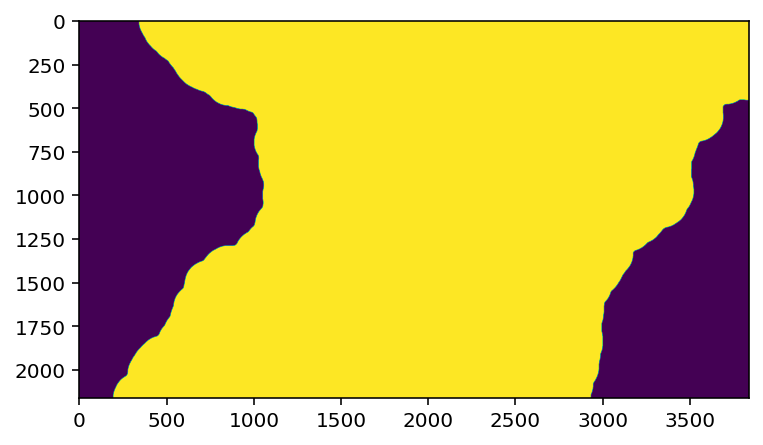

In [586]:
inter = cv2.morphologyEx(sure_bg, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50)))
last = cv2.morphologyEx(inter, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (250, 250)))
last[last > 0] = 1
last = 1-last
plt.imshow(last)


In [601]:
#create RGB Mask For Plotting
maskRGB = np.repeat(last[:, :, np.newaxis], 3, axis=2)

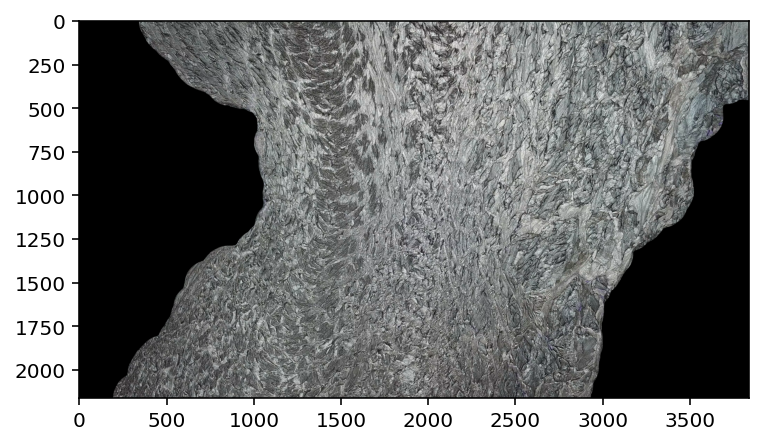

In [602]:
mask_image = img* maskRGB 
plt.imshow(mask_image)

### Apply Mask to PIV (Day example)

Image Footprint: 436.5681486045359 m x 245.56958359005148 m y


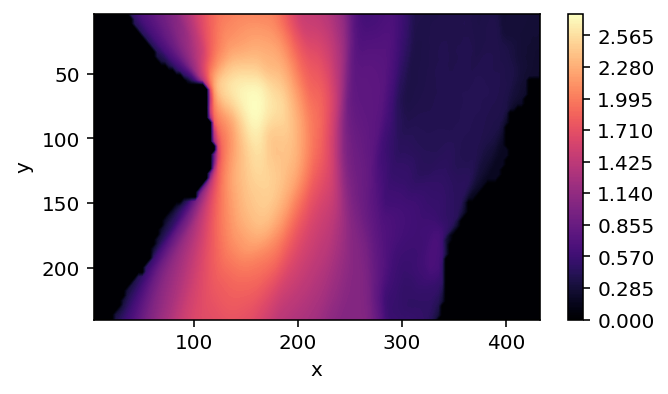

In [609]:
#Daytime
last
AGL = 304.9 #Above ground level (meters) 
FOV =78.8 
FOV = np.deg2rad(FOV) #degrees
Width  = img.shape[1] # float `width` in pixels
Height = img.shape[0]  # float `height` in pixels
Aspect = Height/Width    # CONFIRM THIS IS CORRECT
D =   2 * AGL *np.tan(FOV/2) #diagnol of image
A = (D) / np.sqrt(1 + Aspect**2)
B = Aspect * D / np.sqrt(1 + Aspect**2)
print('Image Footprint:',A, 'm x', B, 'm y')
GSDx = A/ Width #meters per pixel
GSDy = B/ Height #meters per pixel
#select every 32nd pixel based on (overlap=32) from Vid2PIV
pd_mask = pd.DataFrame(last)
pd32_mask = pd_mask.iloc[::32, :]
pd32_mask = pd32_mask[pd32_mask.columns[::32]]

#multiply pixels by m/pixel to convert to meters like PIV field
pd32_mask.columns = pd32_mask.columns * GSDx    #width
pd32_mask.index = pd32_mask.index * GSDy       #height
pd32_mask = pd32_mask.iloc[1:-1, 1:]     #select all but first row and column

#Create copy of PIV to add mask as data variable
PIV_cop = PIV_0802_1350.copy()
PIV_cop = PIV_cop.assign(mask = pd32_mask)

# Mask its own Data Array of 1 and 0s
Mask = PIV_cop.mask
Mask = Mask.rename({'dim_0': 'y','dim_1': 'x'})

#multiply PIV by mask to get PIV_masked
PIV_masked = PIV_cop.s.mean(dim='time') * Mask
#PIV_masked
#optional_plotting
PIV_masked.transpose().plot.contourf( levels=200,yincrease=False,cmap=cm.magma, figsize=(5, (5*(img.shape[0]/img.shape[1]))))

### Nightime

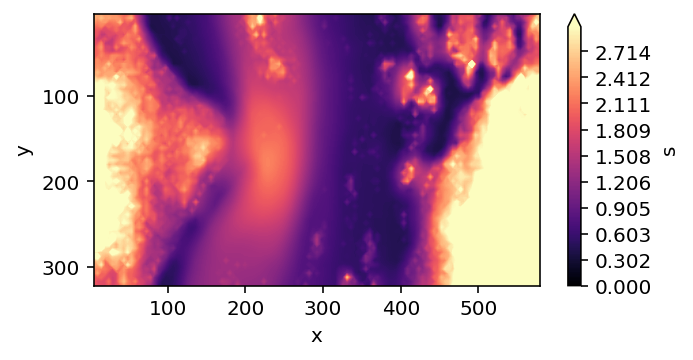

In [333]:

PIV_716_0300 = xr.open_dataset('/Volumes/LaCie/Velocimetry/Site5/0716/0716_0300DJI_0011_vel5_408mAGL.nc')
PIV_716_0300.s.mean(dim='time').transpose().plot.contourf( levels=200,yincrease=False, vmin=0, vmax=3,cmap=cm.magma, figsize=(5,2.5 ))

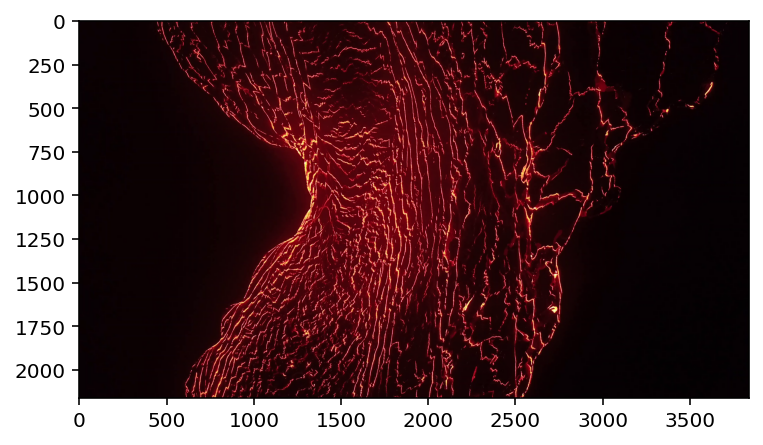

In [3]:
pathIn = '/Volumes/LaCie/Velocimetry/Site5/0716/0716_0300DJI_0011_vel5_408mAGL.MOV'
vidcap = cv2.VideoCapture(pathIn)
success, img = vidcap.read()
img.shape
imgplot = plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Threshold and binarize image

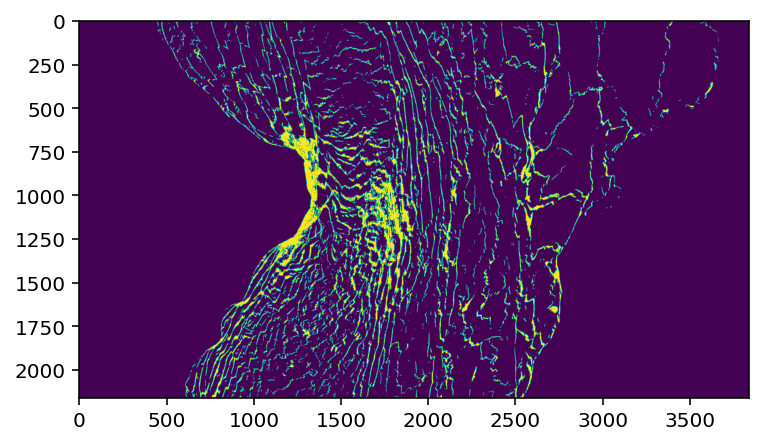

In [335]:
#first grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#since it is lava flow, using the red band
red = img[:, :, 2]

#thresholding 
ret, thresh = cv2.threshold(red,0,255,cv2.THRESH_OTSU)
threshplot = plt.imshow(thresh)

### closing

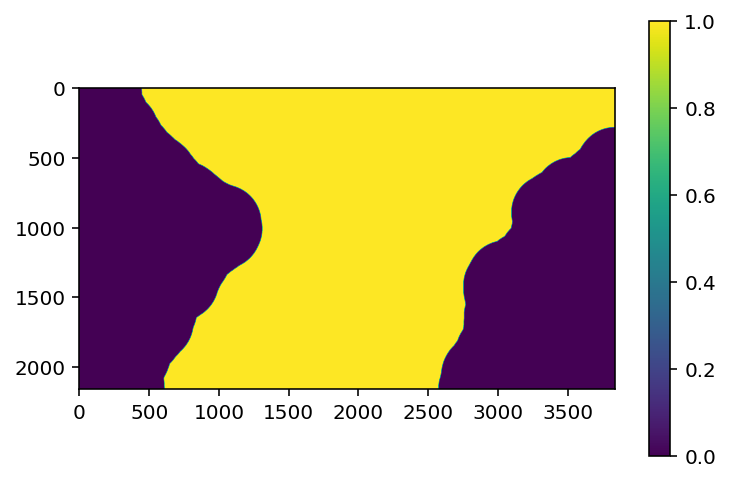

In [336]:
thresh_red = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(thresh.shape[0]*.25),int(thresh.shape[0]*.25))));
thresh_red[thresh_red > 0] = 1
plt.imshow(thresh_red)
plt.colorbar()

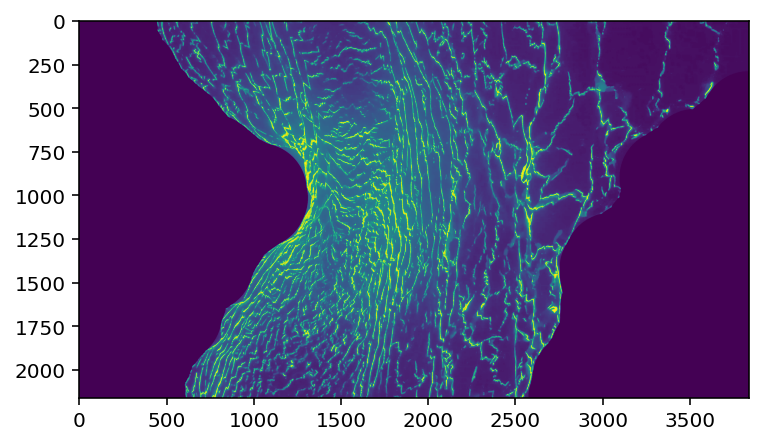

In [495]:
mask_image = img[:, :, 2]* thresh_red
plt.imshow(mask_image)

## Using mask on Xarray

In [340]:
#PIV_717_0328
thresh_red
AGL = 408 #Above ground level (meters) 
FOV =78.8 
FOV = np.deg2rad(FOV) #degrees
Width  = img.shape[1] # float `width` in pixels
Height = img.shape[0]  # float `height` in pixels
Aspect = Height/Width    # CONFIRM THIS IS CORRECT
D =   2 * AGL *np.tan(FOV/2) #diagnol of image
A = (D) / np.sqrt(1 + Aspect**2)
B = Aspect * D / np.sqrt(1 + Aspect**2)
print('Image Footprint:',A, 'm x', B, 'm y')
GSDx = A/ Width #meters per pixel
GSDy = B/ Height #meters per pixel

Image Footprint: 584.1908974439182 m x 328.607379812204 m y


In [341]:
#select every 32nd pixel based on (overlap=32) from Vid2PIV
pd_mask = pd.DataFrame(thresh_red)
pd32_mask = pd_mask.iloc[::32, :]
pd32_mask = pd32_mask[pd32_mask.columns[::32]]

#multiply pixels by m/pixel to convert to meters like PIV field
pd32_mask.columns = pd32_mask.columns * GSDx    #width
pd32_mask.index = pd32_mask.index * GSDy       #height
pd32_mask = pd32_mask.iloc[1:-1, 1:]     #select all but first row and column

In [345]:
#Create copy of PIV to add mask as data variable
PIV_cop = PIV_716_0300.copy()
PIV_cop = PIV_cop.assign(mask = pd32_mask)

# Mask its own Data Array of 1 and 0s
Mask = PIV_cop.mask
Mask = Mask.rename({'dim_0': 'y','dim_1': 'x'})

#multiply PIV by mask to get PIV_masked
PIV_masked = PIV_cop.s.mean(dim='time') * Mask
#PIV_masked

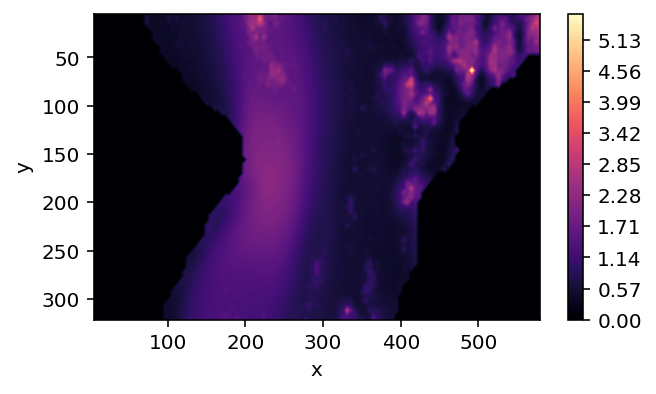

In [346]:
#optional_plotting
PIV_masked.transpose().plot.contourf( levels=200,yincrease=False,cmap=cm.magma, figsize=(5, (5*(img.shape[0]/img.shape[1]))))

# Mask Function

In [1]:
def PIV_mask(pathIn, PIVfile, pathOut, DoN, AGL, FOV, growth):
    
    """ PIV_mask is a function used to mask out backround velocity in the
    regions outside of a lava flow from particle image velocimetry (PIV) 
    derived velocity fields from hovering drone footage. It is meant to be used
    as a post processing tool for the Vid2PIV function, outputting an xaray dataframe.
    
    INPUTS: 
   
    fileIn: Local path to video (.mov or .mp4 file format)
    PIVfile: Local path to PIV field (.nc format)
    fileOut: Name you would like to save your masked velocity .nc file
    DoN: Day or NIGHT: depending on what time the video was taken
    AGL: Above ground level (Altitude of drone) in meters
    FOV: Field of View of sensor in degrees
    growth: Float between 0 and 1, for growing or shrinking mask: start default .25 
            and adjust till mask coverage is appropriate
    
    OUTPUTS: A saved xarray dataset of masked lava flow velocity in .nc file format
    
    """
    #open PIV file in Xarray
    PIV = xr.open_dataset(PIVfile)
    
    #read in still image from video to base mask off of
    vidcap = cv2.VideoCapture(pathIn)
    success, img = vidcap.read()
    
  
    if DoN == 'NIGHT':
        
        #since it is lava flow, using the red band
        red = img[:, :, 2]
        #thresholding using OTSU method 
        ret, thresh = cv2.threshold(red,0,255,cv2.THRESH_OTSU)
        #Morphological closing of holes
        thresh_red = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(thresh.shape[0]*growth),int(thresh.shape[0]*growth))));
        #make binary mask, 1 in lava flow, 0 for background
        thresh_red[thresh_red > 0] = 1
        binary_thresh = thresh_red
    else:
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        
        # noise removal
        kernel = np.ones((10,10),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
        # sure background area
        sure_bg = cv2.dilate(opening,kernel,iterations=3)
        #morphological opening and closeing
        inter = cv2.morphologyEx(sure_bg, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(thresh.shape[0]*(growth/10)), int(thresh.shape[0]*(growth/10)))))
        binary_thresh = cv2.morphologyEx(inter, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(thresh.shape[0]*(growth/2.2)), int(thresh.shape[0]*(growth/2.2)))))
        binary_thresh[binary_thresh > 0] = 1
        binary_thresh = 1-binary_thresh
    
    #Calulate GSD for video
    AGL #meters  
    FOV = np.deg2rad(FOV) #degrees
    Width  = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width` in pixels
    Height = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height` in pixels
    Aspect = Height/Width    # CONFIRM THIS IS CORRECT
    D =   2 * AGL *np.tan(FOV/2) #diagnol of image
    A = (D) / np.sqrt(1 + Aspect**2)
    B = Aspect * D / np.sqrt(1 + Aspect**2)
    GSDx = A/ Width #meters per pixel
    GSDy = B/ Height #meters per pixel
    
    #select every 32nd pixel based on (overlap=32) from Vid2PIV
    pd_mask = pd.DataFrame(binary_thresh)
    pd32_mask = pd_mask.iloc[::32, :]
    pd32_mask = pd32_mask[pd32_mask.columns[::32]]

    #multiply pixels by m/pixel to convert to meters like PIV field
    pd32_mask.columns = pd32_mask.columns * GSDx    #width
    pd32_mask.index = pd32_mask.index * GSDy       #height
    pd32_mask = pd32_mask.iloc[1:-1, 1:]     #select all but first row and column
 

    #Create copy of PIV to add mask as data variable
    PIV_copy = PIV.copy()
    PIV_copy = PIV_copy.assign(mask = pd32_mask)

    # Mask its own Data Array of 1 and 0s
    Mask = PIV_copy.mask
    Mask = Mask.rename({'dim_0': 'y','dim_1': 'x'})

    #multiply PIV by mask to get PIV_masked
    PIV_masked = PIV_copy.s.mean(dim='time') * Mask
    PIV_masked

    PIV_masked.to_netcdf(pathOut)
    
    #optional_plotting
    # PIV_masked.transpose().plot.contourf( levels=200,yincrease=False,cmap=cm.magma, figsize=(5, (5*(img.shape[0]/img.shape[1]))))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return(PIV_masked,img)

In [5]:
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

In [358]:
pathIn = '/Volumes/LaCie/Velocimetry/Site5/0716/0716_0300DJI_0011_vel5_408mAGL.MOV'
pathOut= [pathIn[:-3]+ 'nc'] #change to saved file
PIVfile = listToString(pathOut)
fileOut = [PIVfile[:-4]+'_masked_mean.nc']
fileOut = listToString(fileOut)
fileOut

'/Volumes/LaCie/Velocimetry/Site5/0716/0716_0300DJI_0011_vel5_408mAG_masked_mean.nc'

### Example 

In [9]:
pathIn = '/Volumes/LaCie/Velocimetry/Site4/0724/DJI_0003_20180724_velpt4_2148_1382.2ft.MOV'
pathOut= [pathIn[:-3]+ 'nc'] #change to saved file
pathOut = listToString(pathOut)
PIVfile = pathOut
ft2m = 0.3048
AGL = ft2m * 1382.2 #input ft, get out meters  #Above ground level (meters) 
FOV =78.8     #Field of view (degrees) for mavic 4
fileOut = [PIVfile[:-4]+'_masked_mean.nc']
fileOut = listToString(fileOut)
fileOut

growth = 0.15

DoN = 'NIGHT'

PIV_masked, img = PIV_mask(pathIn, PIVfile, fileOut, DoN, AGL, FOV, growth)

fig.suptitle('Mask PIV field and original reference photo')
plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
PIV_masked.transpose().plot.contourf( levels=200,yincrease=False,cmap=cm.magma, figsize=(5, (5*(img.shape[0]/img.shape[1]))))

NameError: name 'fig' is not defined

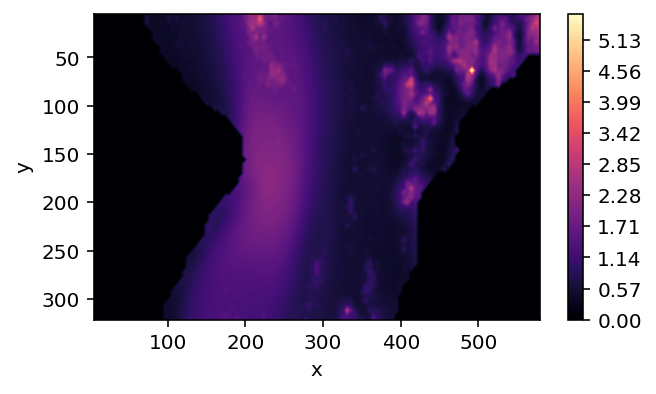

In [469]:
pathIn = '/Volumes/LaCie/Velocimetry/Site5/0716/0716_0300DJI_0011_vel5_408mAGL.MOV'
pathOut= [pathIn[:-3]+ 'nc'] #change to saved file
PIVfile = listToString(pathOut)
fileOut = [PIVfile[:-4]+'_masked_mean_2.nc']
fileOut = listToString(fileOut)
fileOut

ft2m = 0.3048
AGL = 408 #input ft, get out meters  #Above ground level (meters) 
FOV =78.8  

DoN = 'NIGHT'

PIV_masked4_0716_0300 = PIV_mask(pathIn, PIVfile, fileOut, DoN, AGL, FOV)

PIV_masked4_0716_0300.transpose().plot.contourf( levels=200,yincrease=False,cmap=cm.magma, figsize=(5, (5*(img.shape[0]/img.shape[1]))))


### Find Mean, median, Max velocity and area inside of lava flow, excluding Mask

In [488]:
mean = round(float(PIV_masked4_0716_0300.where(PIV_masked4_0716_0300 > 0).mean()),2)
median = round(float(PIV_masked4_0716_0300.where(PIV_masked4_0716_0300 > 0).median()),2)
maxim = round(float(PIV_masked4_0716_0300.where(PIV_masked4_0716_0300 > 0).max()),2)
stdv = round(float(PIV_masked4_0716_0300.where(PIV_masked4_0716_0300 > 0).std()),2)


mean, median, maxim, stdv

(1.06, 0.92, 5.58, 0.54)

### Daytime with cloud noise

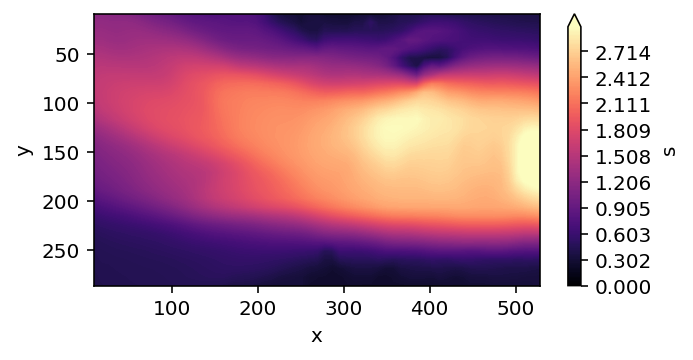

In [532]:

pathIn = '/Volumes/LaCie/Velocimetry/Site4/0726/DJI_0002_20180726_velpt4_1831_1231.6ft.MOV'
pathOut= [pathIn[:-3]+ 'nc'] #change to saved file
pathOut = listToString(pathOut)
AGL = ft2m * 1231.6 #input ft, get out meters  #Above ground level (meters) 
FOV =78.8     #Field of view (degrees) for mavic 4

PIVfile = pathOut
PIV_0802_1350 = xr.open_dataset(PIVfile)
PIV_0802_1350.s.mean(dim='time').transpose().plot.contourf( levels=200,yincrease=False, vmin=0, vmax=3,cmap=cm.magma, figsize=(5,2.5 ))



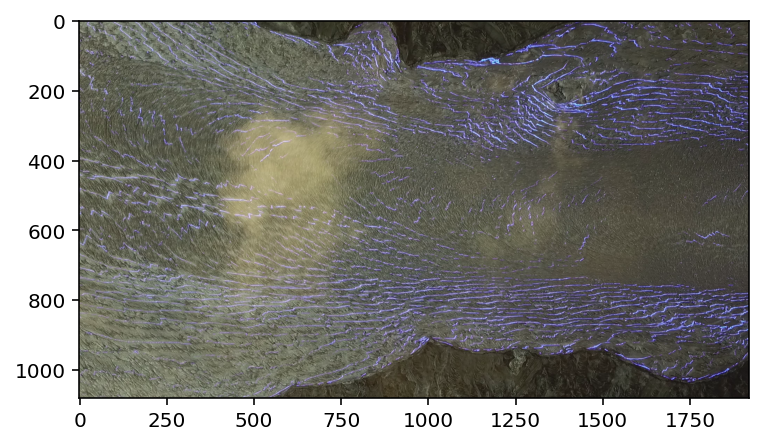

In [554]:
#pathIn = '/Volumes/LaCie/Velocimetry/Site5/0802/DJI_0002_20180802_VelPt5_1350_304.9mAGL.MOV'
vidcap = cv2.VideoCapture(pathIn)
success, img = vidcap.read()
red = img[:, :, 2]
imgplot = plt.imshow(img)
plt.show()

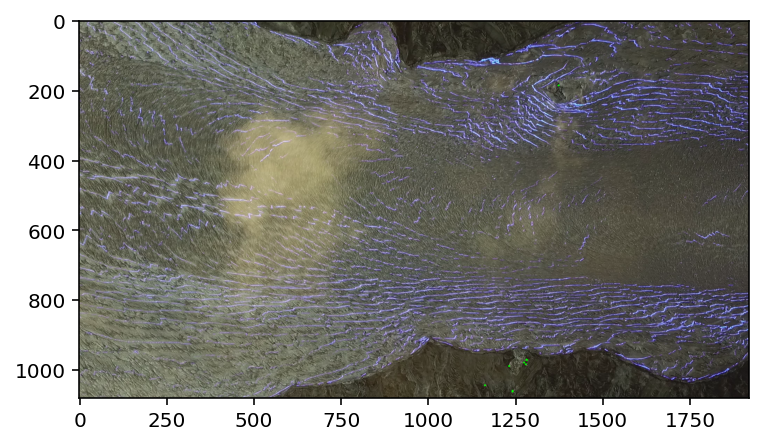

In [553]:
contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#plt.imshow(contours)
for contour in contours:
    cv2.drawContours(img, contour, -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(img)

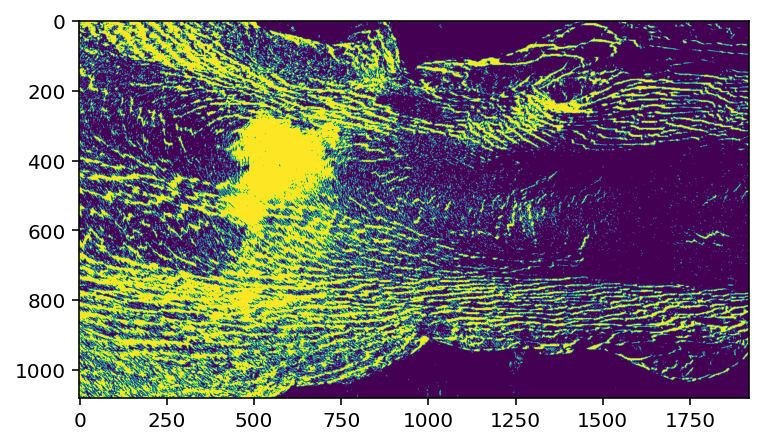

In [545]:
red = img[:, :, 2]
ret, thresh = cv2.threshold(red,0,255,cv2.THRESH_OTSU)
threshplot = plt.imshow(thresh)
#plt.show()

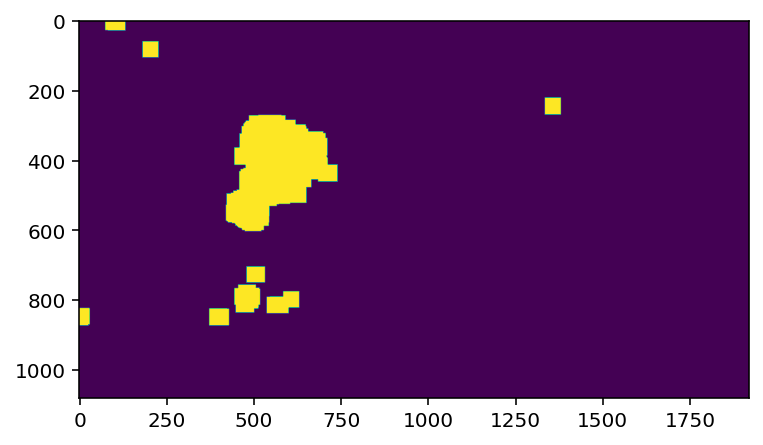

In [540]:
# noise removal
kernel = np.ones((10,10),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = 1 - sure_bg
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(sure_bg)

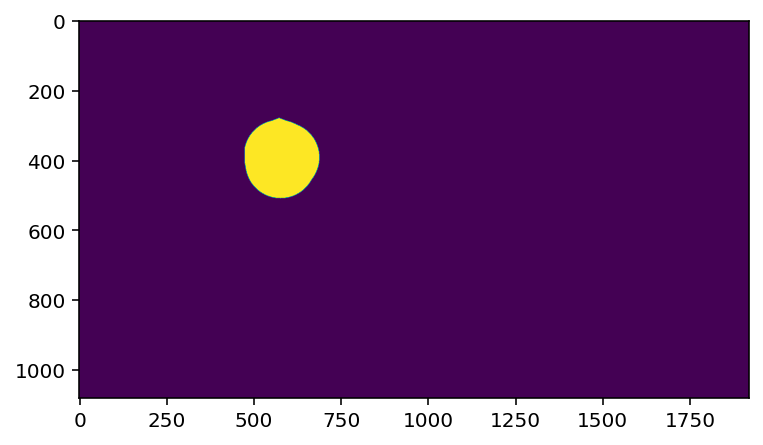

In [541]:
inter = cv2.morphologyEx(sure_bg, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (200, 200)))
last = cv2.morphologyEx(inter, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (600, 600)))

plt.imshow(last)